Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools

from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import KMeans,AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble


In [2]:
df_init = pd.read_csv('BankChurners.csv')
df_init=df_init.drop(df_init.columns[-1], axis=1)
df_init=df_init.drop(df_init.columns[-1], axis=1)
df_init.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [3]:
df_init.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  object 
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           10127 non-null  object 
 6   Marital_Status            10127 non-null  object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

In [4]:
def Category_dtype_Helper(df : pd.DataFrame):
        cols = df.columns
        result_df = pd.DataFrame(columns=("Column","Type","Unique Count", "Total Count","Is Category Good"))
        
        for col in cols:
            col_type = df[col].dtype
            count_unique = df[col].nunique()
            count_total = len(df[col])
            if col_type == object and count_unique < count_total*0.7: 
                cat_good = True
            else:
                cat_good = False            

            result_df.loc[len(result_df.index)]=[col,col_type,count_unique,count_total,cat_good]
        return result_df

def ChangeTypesToCategory(df : pd.DataFrame):
         helper_df = Category_dtype_Helper(df)
         for col in df.columns:
             if helper_df[helper_df["Column"] == col]["Is Category Good"].iloc[0]:           
                 df[col] = df[col].astype("category")



In [5]:
ChangeTypesToCategory(df_init)
df_init.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   CLIENTNUM                 10127 non-null  int64   
 1   Attrition_Flag            10127 non-null  category
 2   Customer_Age              10127 non-null  int64   
 3   Gender                    10127 non-null  category
 4   Dependent_count           10127 non-null  int64   
 5   Education_Level           10127 non-null  category
 6   Marital_Status            10127 non-null  category
 7   Income_Category           10127 non-null  category
 8   Card_Category             10127 non-null  category
 9   Months_on_book            10127 non-null  int64   
 10  Total_Relationship_Count  10127 non-null  int64   
 11  Months_Inactive_12_mon    10127 non-null  int64   
 12  Contacts_Count_12_mon     10127 non-null  int64   
 13  Credit_Limit              10127 non-null  floa

In [6]:
df_init = df_init.rename(columns = {'CLIENTNUM':'Customer_ID'})

In [7]:
tab_info=pd.DataFrame(df_init.dtypes).T.rename(index={0:'column type'})
tab_info=pd.concat([tab_info, pd.DataFrame(df_init.isnull().sum()).T.rename(index={0:'null values (nb)'})])
tab_info=pd.concat([tab_info, pd.DataFrame(df_init.isnull().sum()/df_init.shape[0]*100).T.
                         rename(index={0:'null values (%)'})])
display(tab_info)

,Customer_ID,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
column type,int64,category,int64,category,int64,category,category,category,category,int64,...,int64,int64,float64,int64,float64,float64,int64,int64,float64,float64
null values (nb),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
null values (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
print('Dataframe dimensions:', df_init.shape)

Dataframe dimensions: (10127, 21)


In [9]:
print('Duplicates count: {}'.format(df_init.duplicated().sum()))

Duplicates count: 0


In [10]:
df_init['Attrition_Flag'].unique()

['Existing Customer', 'Attrited Customer']
Categories (2, object): ['Attrited Customer', 'Existing Customer']

In [11]:
df_init['Existing_Customer'] = (df_init['Attrition_Flag'] == 'Existing Customer').astype("int")
df_init = df_init.drop(['Attrition_Flag'], axis=1)

In [12]:
df_init.head()

,Customer_ID,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,...,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Existing_Customer
0,768805383,45,M,3,High School,Married,$60K - $80K,Blue,39,5,...,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,1
1,818770008,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,...,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,1
2,713982108,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,...,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,1
3,769911858,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,...,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,1
4,709106358,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,...,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,1


In [13]:
df = df_init

In [14]:
plt.rc('font', weight='bold')

def plot_dwo_pies(first_data, second_data, labels, colors, plotText, subText1, subText2):
    
    fig = plt.figure(figsize = (15,5))
    ax = fig.add_subplot(1,2,1)
    sizes  = first_data
    explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
    ax.pie(sizes, explode = explode, labels=labels, colors = colors,
        autopct = lambda x:'{:1.1f}%'.format(x) if x > 1 else '',
        shadow = False, startangle=0)
    ax.axis('equal')
    ax.text(0.0, 1.1, subText1, ha='center', fontsize = 18)

    ax = fig.add_subplot(1,2,2)
    sizes  = second_data
    explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
    ax.pie(sizes, explode = explode, labels=labels, colors = colors,
        autopct = lambda x:'{:1.1f}%'.format(x) if x > 1 else '',
        shadow = False, startangle=0)
    ax.axis('equal')
    ax.text(0.0, 1.1, subText2, ha='center', fontsize = 18)
    
    fig.text(0.5, 1.01, plotText, ha='center', fontsize = 18)



    

In [15]:
def plot_dwo_bars(first_data, second_data, labels, colors, plotText, subText1, subText2):
    
    first_data = first_data /sum(first_data)
    second_data = second_data /sum(second_data)

    fig = plt.figure(figsize = (15,5))
    ax = fig.add_subplot(1,1,1)

    ind = np.arange(len(labels))
    width = 0.35 

    rects1 = ax.bar(ind, first_data, width, color=colors[0])

    rects2 = ax.bar(ind+width, second_data, width, color=colors[1])

    ax.set_ylabel('Percent')
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels( labels)
    ax.legend( (rects1[0], rects2[0]), (subText1, subText2) )
    fig.text(0.5, 1.01, plotText, ha='center', fontsize = 18)

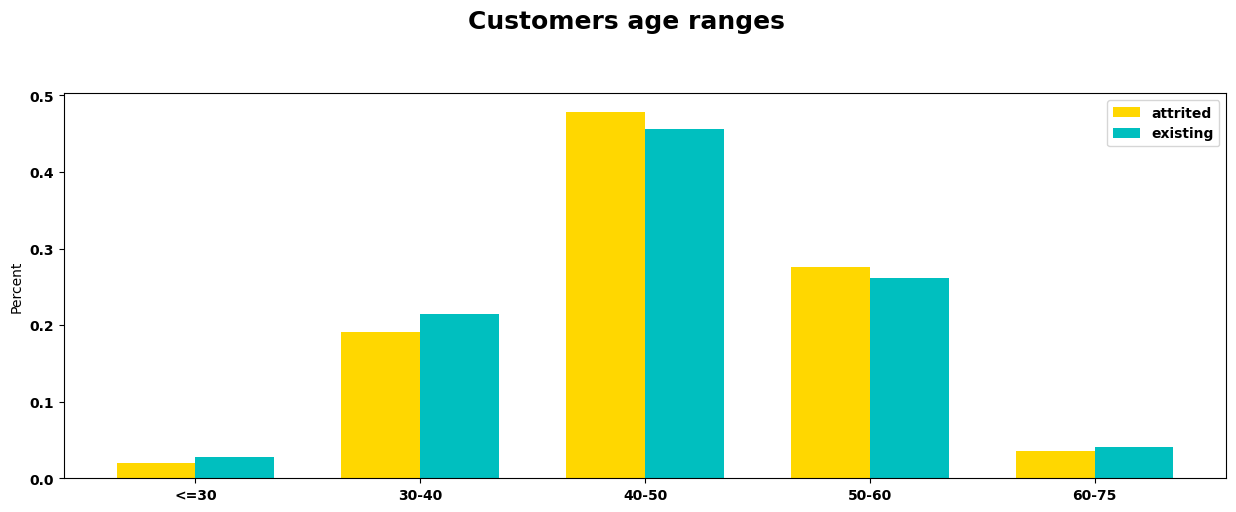

In [16]:
age_range = [0, 30, 40, 50, 60, 75]
count_customers_attrited  = []
count_customers_existing  = []
for i, age in enumerate(age_range):
    if i == 0: 
       continue

    val = df[(df['Customer_Age'] <= age) &
                       (df['Customer_Age'] > age_range[i-1])
                       &  (df['Existing_Customer']==True )]['Customer_Age'].count()
    count_customers_existing.append(val)

    val = df[(df['Customer_Age'] <= age) &
                       (df['Customer_Age'] > age_range[i-1])
                       &  (df['Existing_Customer']==False )]['Customer_Age'].count()
    count_customers_attrited.append(val)



colors = ['gold', 'c', 'violet', 'royalblue','firebrick']
labels = ['<=30']+[ '{}-{}'.format(age_range[i-1], s) for i,s in enumerate(age_range) if i>1 and i<6]

plot_dwo_bars(count_customers_attrited, count_customers_existing, labels, colors[:2], "Customers age ranges", "attrited", "existing")

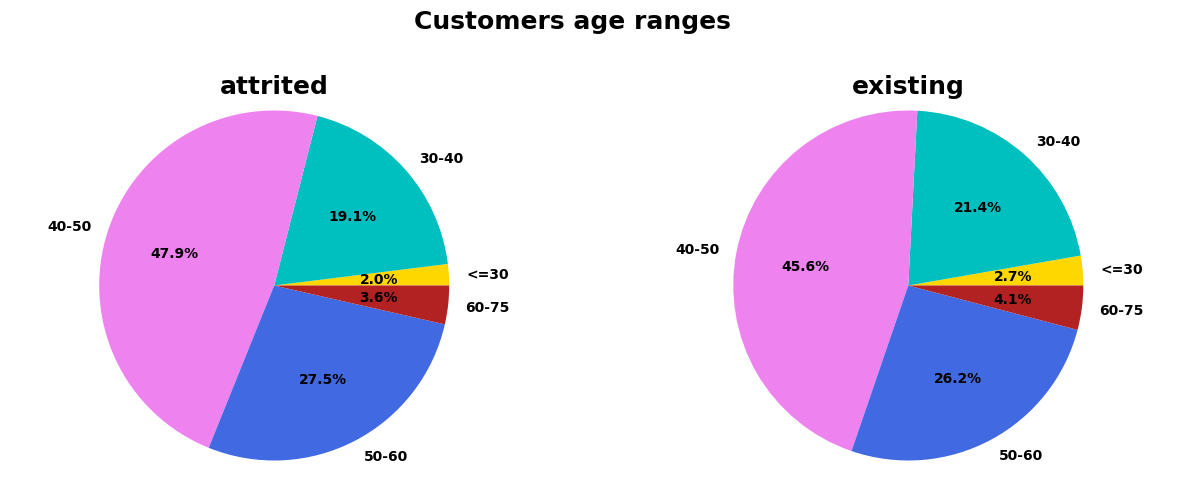

In [17]:
age_range = [0, 30, 40, 50, 60, 75]
count_customers_attrited  = []
count_customers_existing  = []
for i, age in enumerate(age_range):
    if i == 0: 
       continue

    val = df[(df['Customer_Age'] <= age) &
                       (df['Customer_Age'] > age_range[i-1])
                       &  (df['Existing_Customer']==True )]['Customer_Age'].count()
    count_customers_existing.append(val)

    val = df[(df['Customer_Age'] <= age) &
                       (df['Customer_Age'] > age_range[i-1])
                       &  (df['Existing_Customer']==False )]['Customer_Age'].count()
    count_customers_attrited.append(val)


colors = ['gold', 'c', 'violet', 'royalblue','firebrick']
labels = ['<=30']+[ '{}-{}'.format(age_range[i-1], s) for i,s in enumerate(age_range) if i>1 and i<6]

plot_dwo_pies(count_customers_attrited, count_customers_existing, labels, colors, "Customers age ranges", "attrited", "existing")

In [18]:
df['Education_Level'].unique()

['High School', 'Graduate', 'Uneducated', 'Unknown', 'College', 'Post-Graduate', 'Doctorate']
Categories (7, object): ['College', 'Doctorate', 'Graduate', 'High School', 'Post-Graduate', 'Uneducated', 'Unknown']

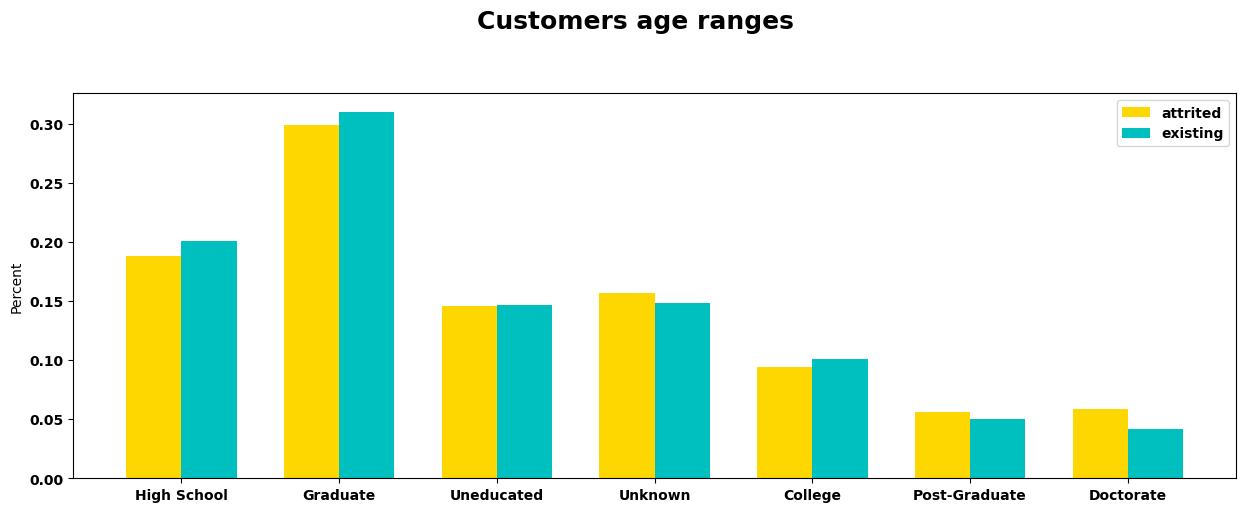

In [19]:
Education_Levels = df['Education_Level'].unique()
count_customers_attrited  = []
count_customers_existing  = []
for i, age in enumerate(Education_Levels):

    val = df[(df['Education_Level'] == Education_Levels[i]) 
                       &  (df['Existing_Customer']==True )]['Education_Level'].count()
    count_customers_existing.append(val)

    val = df[(df['Education_Level'] == Education_Levels[i]) 
                       &  (df['Existing_Customer']==False )]['Education_Level'].count()
    count_customers_attrited.append(val)

colors = ['gold', 'c', 'violet', 'royalblue','firebrick']
labels = Education_Levels

plot_dwo_bars(count_customers_attrited, count_customers_existing, labels, colors[:2], "Customers age ranges", "attrited", "existing")

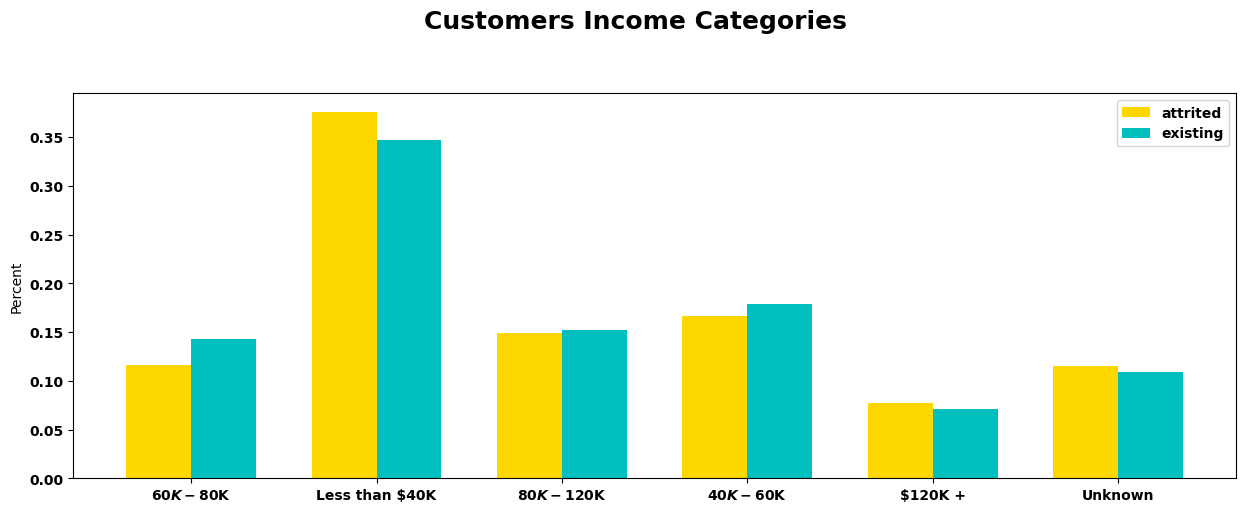

In [20]:
Income_Categories = df['Income_Category'].unique()
count_customers_attrited  = []
count_customers_existing  = []
for i, age in enumerate(Income_Categories):

    val = df[(df['Income_Category'] == Income_Categories[i]) 
                       &  (df['Existing_Customer']==True )]['Income_Category'].count()
    count_customers_existing.append(val)

    val = df[(df['Income_Category'] == Income_Categories[i]) 
                       &  (df['Existing_Customer']==False )]['Income_Category'].count()
    count_customers_attrited.append(val)

colors = ['gold', 'c', 'violet', 'royalblue','firebrick']
labels = Income_Categories

plot_dwo_bars(count_customers_attrited, count_customers_existing, labels, colors[:2], "Customers Income Categories", "attrited", "existing")

In [21]:
df['Card_Category'].unique()

['Blue', 'Gold', 'Silver', 'Platinum']
Categories (4, object): ['Blue', 'Gold', 'Platinum', 'Silver']

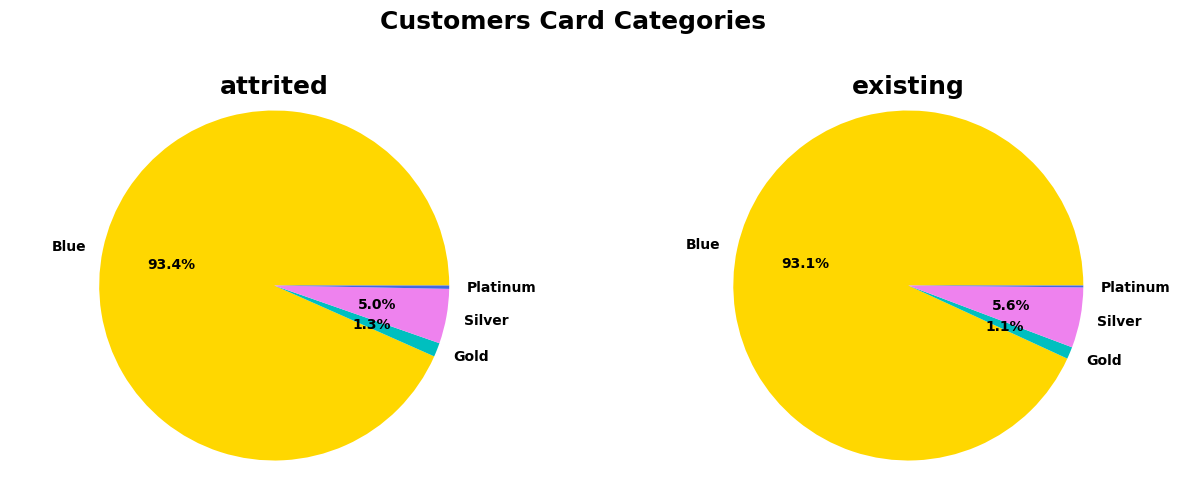

In [22]:
Card_Categories = df['Card_Category'].unique()
count_customers_attrited  = []
count_customers_existing  = []
for i, age in enumerate(Card_Categories):

    val = df[(df['Card_Category'] == Card_Categories[i]) 
                       &  (df['Existing_Customer']==True )]['Card_Category'].count()
    count_customers_existing.append(val)

    val = df[(df['Card_Category'] == Card_Categories[i]) 
                       &  (df['Existing_Customer']==False )]['Card_Category'].count()
    count_customers_attrited.append(val)


colors = ['gold', 'c', 'violet', 'royalblue','firebrick']
labels = Card_Categories

plot_dwo_pies(count_customers_attrited, count_customers_existing, labels, colors, "Customers Card Categories", "attrited", "existing")

In [23]:
df['Months_on_book'].min()

13

In [24]:
df['Months_on_book'].max()

56

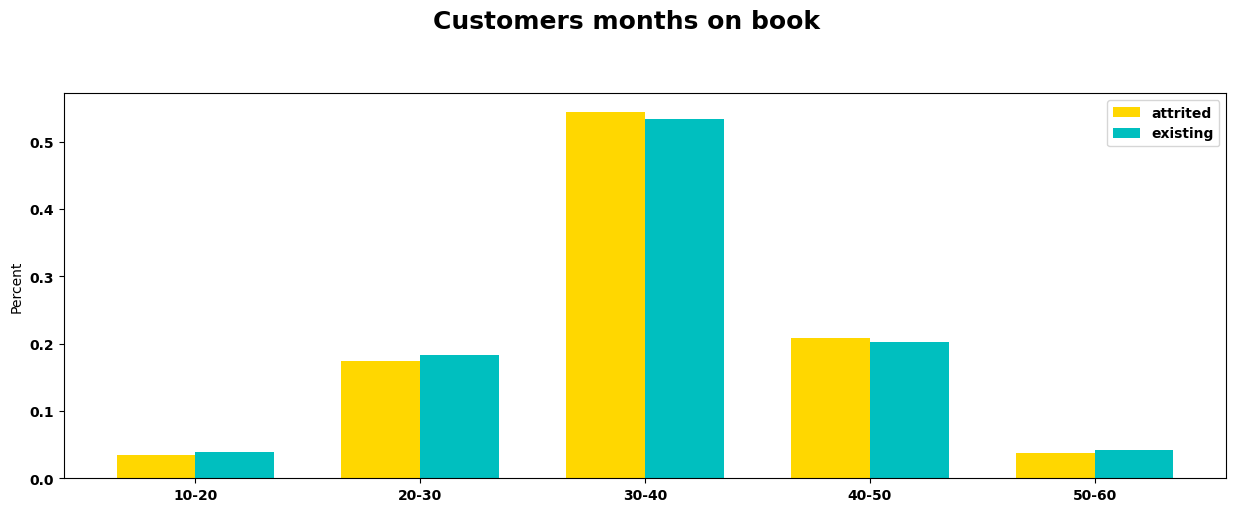

In [25]:
Months_on_book_range = [10, 20, 30, 40, 50, 60]
count_customers_attrited  = []
count_customers_existing  = []
for i, months in enumerate(Months_on_book_range):
    if i == 0: 
       continue

    val = df[(df['Months_on_book'] <= months) &
                       (df['Months_on_book'] > Months_on_book_range[i-1])
                       &  (df['Existing_Customer']==True )]['Months_on_book'].count()
    count_customers_existing.append(val)

    val = df[(df['Months_on_book'] <= months) &
                       (df['Months_on_book'] > Months_on_book_range[i-1])
                       &  (df['Existing_Customer']==False )]['Months_on_book'].count()
    count_customers_attrited.append(val)



colors = ['gold', 'c', 'violet', 'royalblue','firebrick']
labels = [ '{}-{}'.format(Months_on_book_range[i-1], s) for i,s in enumerate(Months_on_book_range) if i>0]

plot_dwo_bars(count_customers_attrited, count_customers_existing, labels, colors[:2], "Customers months on book", "attrited", "existing")

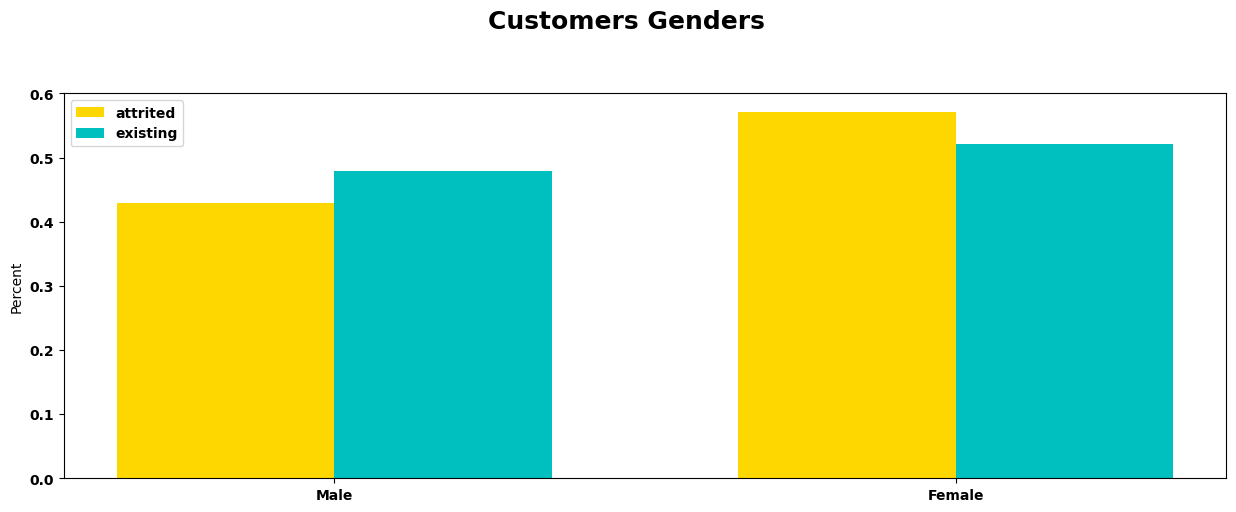

In [26]:
Genders = df['Gender'].unique()
count_customers_attrited  = []
count_customers_existing  = []
for i, ___ in enumerate(Genders):

    val = df[(df['Gender'] == Genders[i]) 
                       &  (df['Existing_Customer']==True )]['Gender'].count()
    count_customers_existing.append(val)

    val = df[(df['Gender'] == Genders[i]) 
                       &  (df['Existing_Customer']==False )]['Gender'].count()
    count_customers_attrited.append(val)


colors = ['gold', 'c', 'violet', 'royalblue','firebrick']
labels = [{'M':'Male','F':'Female'}[g] for g in Genders]

plot_dwo_bars(count_customers_attrited, count_customers_existing, labels, colors[:2], "Customers Genders", "attrited", "existing")

In [27]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [28]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

In [29]:
correlations = df.corr(numeric_only=True)['Existing_Customer']
correlations = correlations.drop(['Existing_Customer', 'Customer_ID', ],axis=0).rename('correlation with diagnosis')
abs_correlations = abs(correlations.rename('abs correlation with diagnosis'))
all_correlations = pd.concat([correlations,abs_correlations],axis=1)
pd.set_option("display.max_rows", 40)
all_correlations.sort_values(by='abs correlation with diagnosis', ascending=False)

,correlation with diagnosis,abs correlation with diagnosis
Total_Trans_Ct,0.371403,0.371403
Total_Ct_Chng_Q4_Q1,0.290054,0.290054
Total_Revolving_Bal,0.263053,0.263053
Contacts_Count_12_mon,-0.204491,0.204491
Avg_Utilization_Ratio,0.178410,0.178410
Total_Trans_Amt,0.168598,0.168598
Months_Inactive_12_mon,-0.152449,0.152449
Total_Relationship_Count,0.150005,0.150005
Total_Amt_Chng_Q4_Q1,0.131063,0.131063
Credit_Limit,0.023873,0.023873


In [30]:
Gender_dummies = pd.get_dummies(df['Gender'], prefix='Gender')
Marital_Status_dummies = pd.get_dummies(df['Marital_Status'], prefix='Marital_Status')
Education_Level_dummies = pd.get_dummies(df['Education_Level'], prefix='Education_Level')
Income_Category_dummies = pd.get_dummies(df['Income_Category'], prefix='Income_Category')
Card_Category_dummies = pd.get_dummies(df['Card_Category'], prefix='Card_Category')

df_encoded = df.drop(['Customer_ID','Gender', 'Marital_Status', 'Education_Level','Income_Category','Card_Category','Existing_Customer'],axis=1)
df_encoded = df_encoded.join([Gender_dummies, Marital_Status_dummies, Education_Level_dummies, Income_Category_dummies, Card_Category_dummies])
df_encoded.head()


,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,...,Income_Category_$120K +,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Income_Category_Unknown,Card_Category_Blue,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
0,45,3,39,5,1,3,12691.0,777,11914.0,1.335,...,0,0,1,0,0,0,1,0,0,0
1,49,5,44,6,1,2,8256.0,864,7392.0,1.541,...,0,0,0,0,1,0,1,0,0,0
2,51,3,36,4,1,0,3418.0,0,3418.0,2.594,...,0,0,0,1,0,0,1,0,0,0
3,40,4,34,3,4,1,3313.0,2517,796.0,1.405,...,0,0,0,0,1,0,1,0,0,0
4,40,3,21,5,1,0,4716.0,0,4716.0,2.175,...,0,0,1,0,0,0,1,0,0,0


In [31]:
matrix = df_encoded.values
for n_clusters in range(5,12):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=50)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 5 The average silhouette_score is : 0.5604653216947388
For n_clusters = 6 The average silhouette_score is : 0.5038085822454291
For n_clusters = 7 The average silhouette_score is : 0.5027012984080469
For n_clusters = 8 The average silhouette_score is : 0.4509376762651128
For n_clusters = 9 The average silhouette_score is : 0.451509755973335
For n_clusters = 10 The average silhouette_score is : 0.411230965710332
For n_clusters = 11 The average silhouette_score is : 0.3711847985635931


In [100]:
n_clusters = 3
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
kmeans.fit(matrix)
clusters = kmeans.predict(matrix)

In [101]:
pd.Series(clusters).value_counts()

0    7003
1    2054
2    1070
dtype: int64

In [102]:
model = AgglomerativeClustering(distance_threshold=None, n_clusters=n_clusters)
model = model.fit(matrix)

In [103]:
model.labels_

array([1, 0, 0, ..., 0, 0, 1], dtype=int64)

In [125]:
def _scale_data(data, ranges):
    (x1, x2) = ranges[0]
    d = data[0]
    return [(d - y1) / (y2 - y1) * (x2 - x1) + x1 for d, (y1, y2) in zip(data, ranges)]

class RadarChart():
    def __init__(self, fig, location, sizes, variables, ranges, n_ordinate_levels = 6):

        angles = np.arange(0, 360, 360./len(variables))

        ix, iy = location[:] ; size_x, size_y = sizes[:]
        
        axes = [fig.add_axes([ix, iy, size_x, size_y], polar = True, 
        label = "axes{}".format(i)) for i in range(len(variables))]

        _, text = axes[0].set_thetagrids(angles, labels = variables)
        
        for txt, angle in zip(text, angles):
            if angle > -1 and angle < 181:
                txt.set_rotation(angle - 90)
            else:
                txt.set_rotation(angle - 270)
        
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            ax.grid("off")
        
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i],num = n_ordinate_levels)
            #print(grid)
            if grid[1] < 1.0:
                grid_label = [""]+["{:.1f}".format(x) for x in grid[1:]]
            else:
                grid_label = [""]+["{:.0f}".format(x) for x in grid[1:]]
            #print(grid_label)
            ax.set_rgrids(grid, labels = grid_label, angle = angles[i])
            ax.set_ylim(*ranges[i])
        
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
                
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def legend(self, *args, **kw):
        self.ax.legend(*args, **kw)
        
    def title(self, title, *args, **kw):
        self.ax.text(0.9, 1, title, transform = self.ax.transAxes, *args, **kw)

In [105]:
list_cols = ['Total_Trans_Ct','Total_Trans_Amt','Credit_Limit','Months_Inactive_12_mon','Credit_Limit','Total_Amt_Chng_Q4_Q1','Avg_Utilization_Ratio']
selected_customers = df.copy(deep = True)
matrix = selected_customers[list_cols].values

In [106]:
scaler = StandardScaler()
scaler.fit(matrix)
print('variables mean values: \n' + 90*'-' + '\n' , scaler.mean_)
scaled_matrix = scaler.transform(matrix)

variables mean values: 
------------------------------------------------------------------------------------------
 [6.48586946e+01 4.40408630e+03 8.63195370e+03 2.34116718e+00
 8.63195370e+03 7.59940654e-01 2.74893552e-01]


In [107]:
selected_customers.loc[:, 'cluster'] = model.labels_

In [109]:
merged_df = pd.DataFrame()
for i in range(n_clusters):
    test = pd.DataFrame(selected_customers[selected_customers['cluster'] == i].mean(numeric_only=True))
    test = test.T.set_index('cluster', drop = True)
    test['size'] = selected_customers[selected_customers['cluster'] == i].shape[0]
    merged_df = pd.concat([merged_df, test])

merged_df.drop('Customer_ID', axis = 1, inplace = True)
print('number of customers:', merged_df['size'].sum())

merged_df = merged_df.sort_values('size')

number of customers: 10127


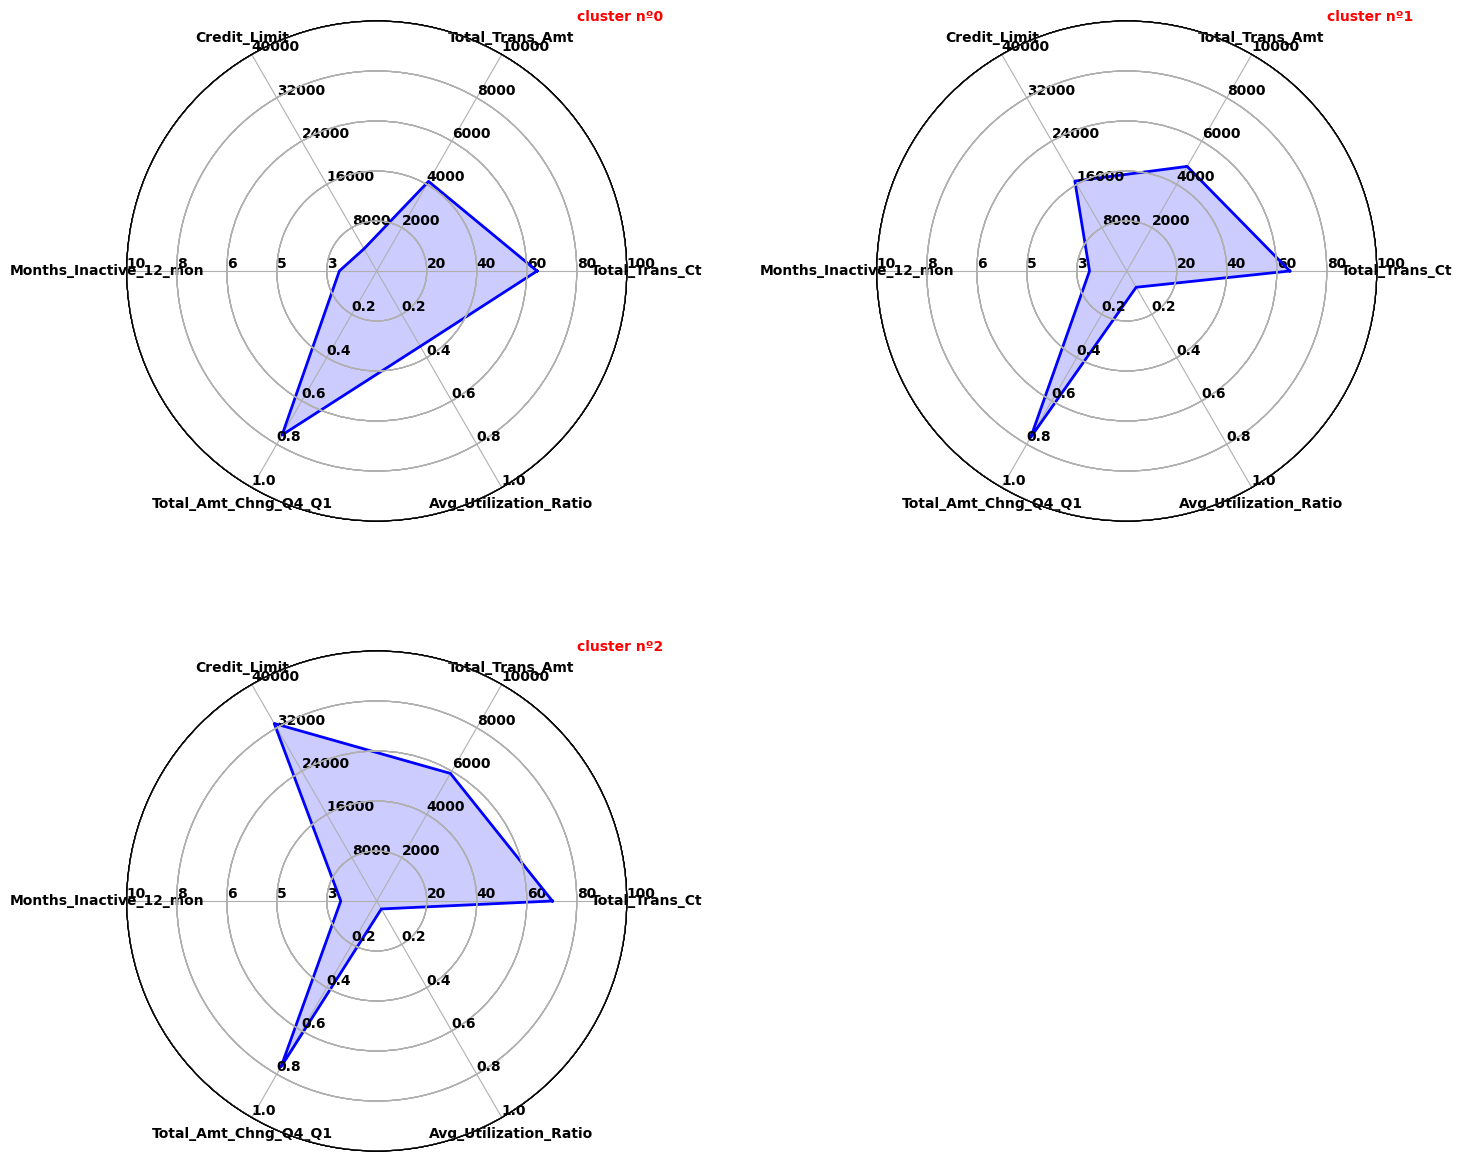

In [139]:
fig = plt.figure(figsize=(10,6))

attributes = ['Total_Trans_Ct','Total_Trans_Amt','Credit_Limit','Months_Inactive_12_mon','Total_Amt_Chng_Q4_Q1','Avg_Utilization_Ratio']
ranges = [[0.1, 100],[0, 10000],[0, 40000],[1, 10],[0.0, 1.0],[0.0, 1.0]]#[[0.01, 10], [0.01, 1500], [0.01, 10000], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75]]
index  = [i for i in range(n_clusters)] 
n_groups = n_clusters ; i_cols = 2
i_rows = n_groups//i_cols
size_x, size_y = (1/i_cols), (1/i_rows)

for ind in range(n_clusters):
    ix = ind%2 ; iy = i_rows - ind//2
    pos_x = ix*(size_x + 0.25) ; pos_y = iy*(size_y + 0.05)            
    location = [pos_x, pos_y]  ; sizes = [size_x, size_y] 
    #______________________________________________________
    data = np.array(merged_df.loc[index[ind], attributes])    
    radar = RadarChart(fig, location, sizes, attributes, ranges,n_ordinate_levels = 6)
    radar.plot(data, color = 'b', linewidth=2.0)
    radar.fill(data, alpha = 0.2, color = 'b')
    radar.title(title = 'cluster nº{}'.format(index[ind]), color = 'r')
    ind += 1 